# Lab 7: Non-negative Matrix Factorization

The goal of this lab session is to code a NMF algorithm and use it in some applications.

You have to send the filled notebook named **"L7_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com before 23:59 on December 5, 2018 and put **"AML-L7"** in the subject. 

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## NMF

Non-negative Matrix Factorization is a model where a matrix V is factorized into two matrices W and H, with the property that all three matrices have no negative elements. This non-negativity makes the resulting matrices easier to interpret.

Fill in the following class that implements a NMF by multiplicative updates using the Frobenius norm or the Kullback-Leiber divergence as loss function (implement both), you can add more methods if needed. Try 10 different random initializations and choose the best one.

In [18]:
class my_NMF():
    
    def __init__(self, n_components, loss, epsilon, max_iter = 200, mu = 0, nu = 0, lam = 0):
        '''
        Attributes:
        
        n_components_ : integer
            the unknown dimension of W and H
        max_iter_: integer
            maximum number of iterations
        epsilon_: float
            convergence
        loss_ = {"Frobenius", "KL"}
        w_: np.array
            W Matrix factor
        H_: np.array
            H Matrix factor
        '''
        self.n_components_ = n_components
        self.loss_ = loss
        self.epsilon_ = epsilon
        self.W_ = None
        self.H_ = None
        self.mu_ = mu
        self.nu_ = nu
        self.lam_ = lam
        self.max_iter_ = max_iter
        
    def fit_transform(self, X):
        """ Find the factor matrices W and H
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """        
        # TODO:
        # initialize both matrices
        #            random(0, 1)
        n, p = X.shape
        #initialiser avec SVD
        #c'est mieux parce que une SVD c'est une PCA et on laisse tomber
        #les contraintes de la PCA pour imposer de nouvelles contraintes
        #régulariser avec la norme 1 de F pour sparsity
        
        def positive_matrix(matrix):
            row = np.where(matrix <= 0)[0]
            col = np.where(matrix <= 0)[1]
            for i in range(len(row)):
                matrix[row[i],col[i]] = 1e-3
            return matrix
        
        #Initialisation with SVD
        u, s, vh = np.linalg.svd(X)
        print(u.shape)
        print(np.diag(s).shape)
        print(vh.shape)
        self.W_ = positive_matrix(u)
        self.H_ = positive_matrix(np.diag(s)@vh)
        self.W_ = self.W_[0:n,0:self.n_components_]
        self.H_ = self.H_[0:self.n_components_,0:p]

        
#         #Initialisation with random
#         self.W_ = np.random.rand(n, self.n_components_)
#         self.H_ = np.random.rand(self.n_components_, p)


        Ir = np.eye(self.n_components_)
        Irp = np.ones((self.n_components_,p))
        iteration = 0
        
        while iteration < self.max_iter_:
            mat_1 = (X@self.H_.T)/(self.W_@(self.H_@self.H_.T+self.nu_*Ir))
            self.W_ = self.W_*mat_1
            mat_2 = (self.W_.T@X - self.lam_*Irp)/((self.W_.T@self.W_+self.mu_*Ir)@self.H_)
            self.H_ = self.H_*mat_2
            iteration += 1
        return self

We decided to initialise our NMF algorithm by using a singular value decomposition (SVD). We decided to use this method instead of initialising the two matrices randomly because using the SVD decomposition is like applying principal component analysis to our problem. Thus, we have found a solution to the problem of minimzing the Frobenius norm of (X - WH) where W must be orthogonal and H be defined as H@H.T = diag(a1, a2, ...) with a1, a2, ... the singular values of the matrix S. Now our algorithm will use the solution found for the SVD and look for a solution that follow the following contraints, W and H must have strictly positive coefficients.

## Applications

### First application

For the first application you are going to analyse the following data to give an interpretation of the factorization:

(400, 4096)


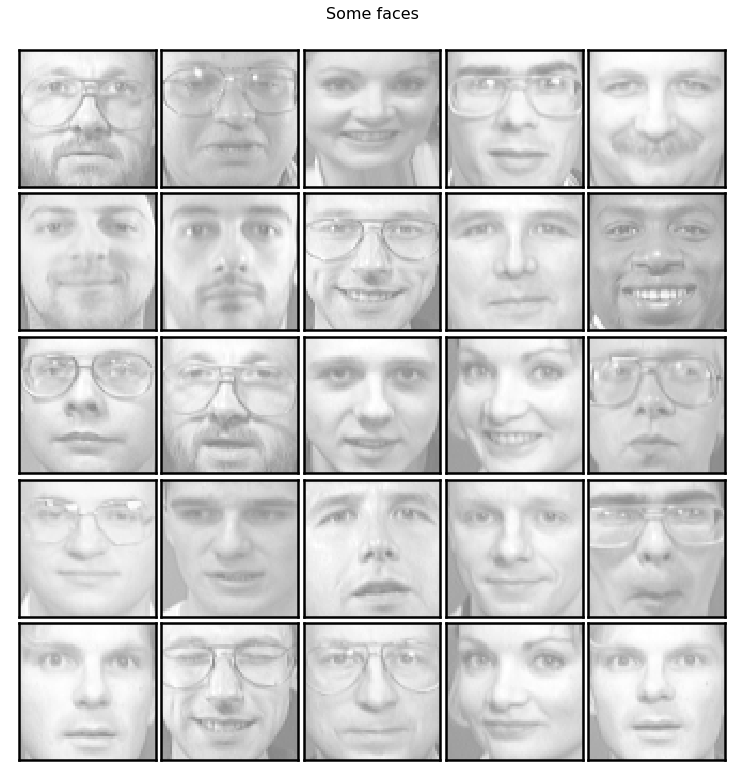

In [11]:
from sklearn.datasets import fetch_olivetti_faces

dataset = fetch_olivetti_faces(shuffle=True)

faces = dataset.data
image_shape = (64, 64)

n_samples, n_features = faces.shape

def plot_faces(title, images, image_shape, n_col=5, n_row=5, cmap=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    
plot_faces("Some faces", faces[:25], image_shape)

print(faces.shape)

Apply your NMF algorithm for this dataset and plot the approximated face pictures.

### Value of the dimension r

To find the best value for the dimension r, one possibility is plotting the variations of the frobenius norm of X - WH where W and H are the matrices found by our algorithm. Similarly to PCA, we should find a dimension r_max for which increasing the dimension doesn't really add any more information. Thus we will choose r_max to be the value at the elbow of the graph.

In [ ]:
r_values = [i for i in range(1,51)]
norm_dif = []
for r in r_values:
    my_model = my_NMF(r, 'Frobenius', 1e-3)
    my_model.fit_transform(faces)
    W = my_model.W_
    H = my_model.H_
    norm_dif.append(np.linalg.norm(faces-W@H))
    
plt.plot(norm_dif)
#Dans l'idéal il faudrait voir un coude dans le graph. 
#On le voit pas trop la mais il faudrait tracer le graphe pour des valeurs de r encore plus grandes 
#mais ça prend pas mal de temps

### Testing our model for the chosen value of r on the faces dataset

In [19]:
r = 100
my_model = my_NMF(r, 'Frobenius', 1e-3)
my_model.fit_transform(faces.T)
W = my_model.W_
H = my_model.H_

(4096, 4096)
(400, 400)
(400, 400)


(4096, 100)
(100, 400)


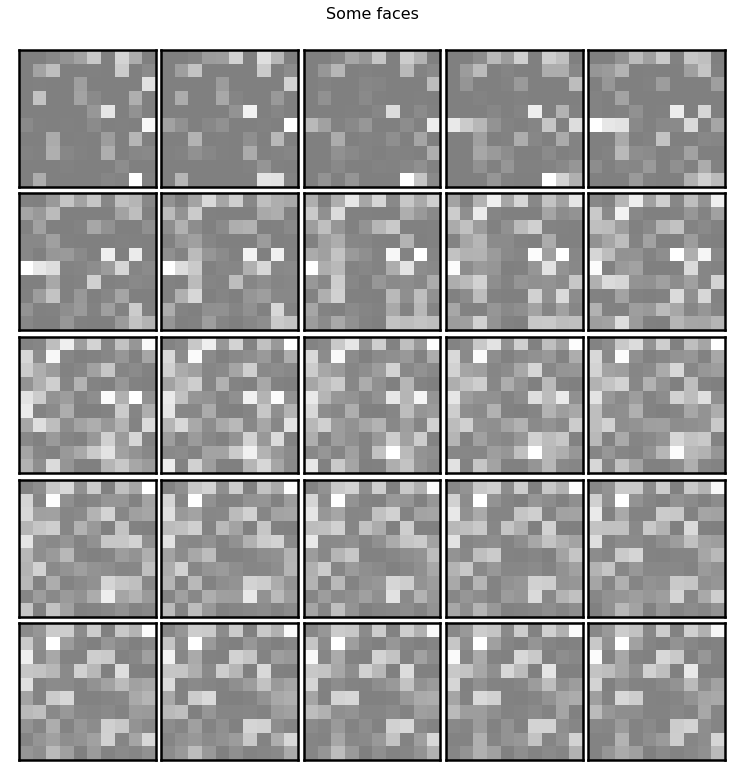

In [26]:
print(W.shape)
print(H.shape)
image_shape = (10,10)
plot_faces("Some faces", W[:25], image_shape)
#je sais pas trop si on est censé faire ça

- Plot the $W$ matrix as images in a $(\sqrt{r}, \sqrt{r})$ grid
- Choose one face, plot its corresponding weights (in $H$) in a grid  and explain the interpretation of both factor matrices.

(4096, 25)


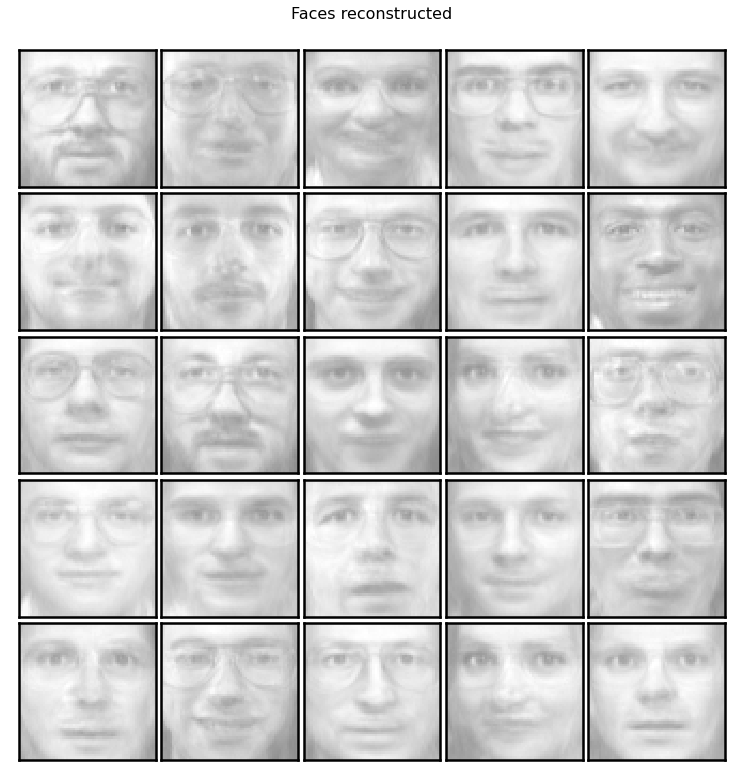

In [32]:
# TODO
#X_approx_0 = np.zeros()
n, p = faces.shape
faces_reconstructed = np.zeros((25,p))
image_shape = (64, 64)
for j in range(25):
    for i in range(r):
        faces_reconstructed[j,:] += W[j,i]*H[i,:]
plot_faces("Faces reconstructed",faces_reconstructed, image_shape)

### Second application

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 newsgroup documents from 20 different newsgroups.

Model the topics present in a subsample with *scikit-learn's* NMF. Print the most common words of each topic. 

Discuss.

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20


def print_top_words(D, feature_names, n_top_words):
    p, r = D.shape
    for topic_idx in range(r):
        topic = D[:, topic_idx]
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


dataset = fetch_20newsgroups(shuffle=True, random_state=1,
                             remove=('headers', 'footers', 'quotes'))
data_samples = dataset.data[:n_samples]


# Use tf-idf features for NMF.
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data_samples)

# Fit the NMF model, print top words

# TODO
from sklearn.decomposition import NMF
nmf = NMF(n_components, random_state=1).fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#print(tfidf_feature_names)
print(tfidf)
W = nmf.fit_transform(tfidf)
H = nmf.components_

print_top_words(nmf.components_.T, tfidf_feature_names, n_top_words)

  (0, 134)	0.13595955391213657
  (0, 210)	0.15810189392327795
  (0, 289)	0.11115911128919416
  (0, 411)	0.11650651629173196
  (0, 413)	0.12831668397369733
  (0, 433)	0.13369075280946802
  (0, 490)	0.3750048191807266
  (0, 495)	0.1631127602376565
  (0, 529)	0.1690393571774018
  (0, 550)	0.11873384536901997
  (0, 568)	0.13595955391213657
  (0, 588)	0.6454209423982519
  (0, 709)	0.12621877625178227
  (0, 718)	0.17767638066823058
  (0, 749)	0.13595955391213657
  (0, 751)	0.15376128408643466
  (0, 765)	0.1640284908630232
  (0, 841)	0.18564440175793037
  (0, 862)	0.1551447391479567
  (0, 867)	0.15810189392327795
  (0, 881)	0.11227372176926384
  (0, 904)	0.08983671288492111
  (0, 923)	0.11966934266418663
  (0, 988)	0.12740095334833063
  (1, 68)	0.1864088181590009
  :	:
  (1998, 842)	0.05564119176953402
  (1998, 856)	0.17617677611631855
  (1998, 869)	0.058153357484531855
  (1998, 906)	0.09485430339000309
  (1998, 907)	0.06891752552161803
  (1998, 908)	0.04862961987309495
  (1998, 911)	0.055416

In [38]:
new_data_sample = dataset.data[2036]  # unseen
print(new_data_sample)


Didn't Paul write that if the Resurrection is not true, we are the
biggest fools of all?  However, whether you believe in Christ or not,
His teachings (e.g. love your brotherman as yourself), even if only 
followed at a secular level, could do a great deal to alleviate some of 
the problems we see today in the world.  Even when I was a rabid atheist 
I couldn't deny that.


In [52]:
#Approximation
#print(len(dataset.data))
approx = W@H
print(approx.shape)
print_top_words(nmf.components_.T, W, n_top_words)
# approx = np.zeros((1,p))
# for i in range(n_components):
#     approx[0,:] += W[2036,i]*H[i,:]
# print

(2000, 1000)


TypeError: sequence item 0: expected str instance, numpy.ndarray found